In [1]:
%matplotlib inline
from IPython.display import display

import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
import os
import sys

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#logging
from MyPyUtil.logconf import logging
log = logging.getLogger(__name__)
# log.setLevel(logging.ERROR)
log.setLevel(logging.INFO)
# log.setLevel(logging.WARN)
# log.setLevel(logging.DEBUG)


#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = '{:.3f}'.format

# max output width in numpy
np.set_printoptions(
    threshold=sys.maxsize,  # 20,
    edgeitems=10,
    linewidth=140,
    formatter=dict(float=lambda x: "%.3g" % x),
)  # float arrays %.3g


torch.seed = 42
random.seed(42)
np.random.seed(42)

%run 'nb_utils.ipynb'
task_name = "StockPCTLabelPredictLSTM_A4" # get_filename_of_ipynb()
print(task_name)
data_dir = f'{os.getcwd()}/data/'
log_dir_base = f'{os.getcwd()}/runs/{task_name}'
if os.path.exists(log_dir_base) == False:
    os.mkdir(log_dir_base)
log_dir = log_dir_base
print(f'{data_dir}\n{log_dir}')


StockPCTLabelPredictLSTM_A4
/mnt/AIWorkSpace/work/AI4StockMarket/data/
/mnt/AIWorkSpace/work/AI4StockMarket/runs/StockPCTLabelPredictLSTM_A4


In [2]:
import torch

device_name = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device = torch.device(device_name)
return_period = 5
seq_len = 3
validation_size = 0.2
epoch_num = 100
batch_size = 32
num_workers = 2
pin_memory = True
shuffle = True
empty_vol_threshold = 5
print(f"device_name:{device}")

device_name:cuda


In [3]:
# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler

ray.init(log_to_driver=False)

2024-03-01 15:51:00,093	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.18
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8265


In [4]:
# stk_symbols = [
#     "AAPL",
#     "MSFT",
#     "AMZN",
#     "NVDA",
#     "GOOGL",
#     "GOOG",
#     "META",
#     "TSLA",
#     "UNH",
#     "LLY",
#     "JPM",
#     "XOM",
#     "JNJ",
#     "V",
#     "PG",
#     "AVGO",
#     "MA",
#     "HD",
#     "CVX",
#     "MRK",
#     "ABBV",
#     "PEP",
#     "COST",
#     "ADBE",
#     "KO",
#     "CSCO",
#     "WMT",
#     "TMO",
#     "MCD",
#     "PFE",
#     "CRM",
#     "BAC",
#     "ACN",
#     "CMCSA",
#     "LIN",
#     "NFLX",
#     "ABT",
#     "ORCL",
#     "DHR",
#     "AMD",
#     "WFC",
#     "DIS",
#     "TXN",
#     "PM",
#     "VZ",
#     "INTU",
#     "COP",
#     "CAT",
#     "AMGN",
#     "NEE",
#     "INTC",
#     "UNP",
#     "LOW",
#     "IBM",
#     "BMY",
#     "SPGI",
#     "RTX",
#     "HON",
#     "BA",
#     "UPS",
#     "GE",
#     "QCOM",
#     "AMAT",
#     "NKE",
#     "PLD",
#     "NOW",
#     "BKNG",
#     "SBUX",
#     "MS",
#     "ELV",
#     "MDT",
#     "GS",
#     "DE",
#     "ADP",
#     "LMT",
#     "TJX",
#     "T",
#     "BLK",
#     "ISRG",
#     "MDLZ",
#     "GILD",
#     "MMC",
#     "AXP",
#     "SYK",
#     "REGN",
#     "VRTX",
#     "ETN",
#     "LRCX",
#     "ADI",
#     "SCHW",
#     "CVS",
#     "ZTS",
#     "CI",
#     "CB",
#     "AMT",
#     "SLB",
#     "C",
#     "BDX",
#     "MO",
#     "PGR",
#     "TMUS",
#     "FI",
#     "SO",
#     "EOG",
#     "BSX",
#     "CME",
#     "EQIX",
#     "MU",
#     "DUK",
#     "PANW",
#     "PYPL",
#     "AON",
#     "SNPS",
#     "ITW",
#     "KLAC",
#     "LULU",
#     "ICE",
#     "APD",
#     "SHW",
#     "CDNS",
#     "CSX",
#     "NOC",
#     "CL",
#     "MPC",
#     "HUM",
#     "FDX",
#     "WM",
#     "MCK",
#     "TGT",
#     "ORLY",
#     "HCA",
#     "FCX",
#     "EMR",
#     "PXD",
#     "MMM",
#     "MCO",
#     "ROP",
#     "CMG",
#     "PSX",
#     "MAR",
#     "PH",
#     "APH",
#     "GD",
#     "USB",
#     "NXPI",
#     "AJG",
#     "NSC",
#     "PNC",
#     "VLO",
#     "GBP",
#     "F",
#     "MSI",
#     "GM",
#     "TT",
#     "EW",
#     "CARR",
#     "AZO",
#     "ADSK",
#     "TDG",
#     "ANET",
#     "SRE",
#     "ECL",
#     "OXY",
#     "PCAR",
#     "ADM",
#     "MNST",
#     "KMB",
#     "PSA",
#     "CCI",
#     "CHTR",
#     "MCHP",
#     "MSCI",
#     "CTAS",
#     "WMB",
#     "AIG",
#     "STZ",
#     "HES",
#     "NUE",
#     "ROST",
#     "AFL",
#     "AEP",
#     "IDXX",
#     "D",
#     "TEL",
#     "JCI",
#     "MET",
#     "GIS",
#     "IQV",
#     "EXC",
#     "WELL",
#     "DXCM",
#     "HLT",
#     "ON",
#     "COF",
#     "PAYX",
#     "TFC",
#     "USD",
#     "BIIB",
#     "O",
#     "FTNT",
#     "DOW",
#     "TRV",
#     "DLR",
#     "MRNA",
#     "CPRT",
#     "ODFL",
#     "DHI",
#     "YUM",
#     "SPG",
#     "CTSH",
#     "AME",
#     "BKR",
#     "SYY",
#     "A",
#     "CTVA",
#     "CNC",
#     "EL",
#     "AMP",
#     # "CEG",  # PCT <= -0.05,  size = 0
#     "HAL",
#     # "OTIS",  # PCT <= -0.05,  size = 0
#     "ROK",
#     "PRU",
#     "DD",
#     "KMI",
#     "VRSK",
#     "LHX",
#     "DG",
#     "FIS",
#     "CMI",
#     "CSGP",
#     "FAST",
#     "PPG",
#     "GPN",
#     "GWW",
#     "HSY",
#     "BK",
#     "XEL",
#     "DVN",
#     "EA",
#     "NEM",
#     "ED",
#     "URI",
#     "VICI",
#     "PEG",
#     "KR",
#     "RSG",
#     "LEN",
#     "PWR",
#     "WST",
#     "COR",
#     "OKE",
#     "VMC",
#     "KDP",
#     "WBD",
#     "ACGL",
#     "ALL",
#     "IR",
#     "CDW",
#     "FANG",
#     "MLM",
#     "PCG",
#     "DAL",
#     "EXR",
#     "FTV",
#     "AWK",
#     "IT",
#     "KHC",
#     # "GEHC",  # PCT <= -0.05,  size = 0
#     "WEC",
#     "HPQ",
#     "EIX",
#     "CBRE",
#     "APTV",
#     "ANSS",
#     "MTD",
#     "DLTR",
#     "AVB",
#     "ILMN",
#     "ALGN",
#     "LYB",
#     "TROW",
#     "GLW",
#     "EFX",
#     "WY",
#     "ZBH",
#     "XYL",
#     "SBAC",
#     "RMD",
#     "TSCO",
#     "EBAY",
#     "KEYS",
#     "CHD",
#     "STT",
#     "DFS",
#     "HIG",
#     "ALB",
#     "STE",
#     "ES",
#     "TTWO",
#     "MPWR",
#     "CAH",
#     "EQR",
#     "RCL",
#     "WTW",
#     "HPE",
#     "DTE",
#     "GPC",
#     "BR",
#     "ULTA",
#     "FICO",
#     "CTRA",
#     "BAX",
#     "AEE",
#     "MTB",
#     "MKC",
#     "ETR",
#     "WAB",
#     "DOV",
#     "FE",
#     "RJF",
#     "INVH",
#     "FLT",
#     "CLX",
#     "TDY",
#     "TRGP",
#     "DRI",
#     "LH",
#     "HOLX",
#     "VRSN",
#     "MOH",
#     "LUV",
#     "PPL",
#     "ARE",
#     "NVR",
#     "COO",
#     "WBA",
#     "PHM",
#     "NDAQ",
#     "HWM",
#     "RF",
#     "CNP",
#     "IRM",
#     "LVS",
#     "FITB",
#     "EXPD",
#     "VTR",
#     "FSLR",
#     "PFG",
#     "BRO",
#     "J",
#     "IEX",
#     "BG",
#     "ATO",
#     "FDS",
#     "ENPH",
#     "MAA",
#     "CMS",
#     "IFF",
#     "BALL",
#     "SWKS",
#     "CINF",
#     "NTAP",
#     "STLD",
#     "UAL",
#     "WAT",
#     "OMC",
#     "TER",
#     "CCL",
#     "JBHT",
#     "MRO",
#     "TYL",
#     "HBAN",
#     "K",
#     "GRMN",
#     "CBOE",
#     "NTRS",
#     "TSN",
#     "AKAM",
#     "EG",
#     "ESS",
#     "EQT",
#     "TXT",
#     "EXPE",
#     "SJM",
#     "PTC",
#     "DGX",
#     "AVY",
#     "RVTY",
#     "BBY",
#     "CF",
#     "CAG",
#     "EPAM",
#     "AMCR",
#     "LW",
#     "PAYC",
#     "SNA",
#     "AXON",
#     "POOL",
#     "SYF",
#     "SWK",
#     "ZBRA",
#     "DPZ",
#     "PKG",
#     "CFG",
#     "LDOS",
#     "VTRS",
#     "PODD",
#     "LKQ",
#     "MOS",
#     "APA",
#     "EVRG",
#     "TRMB",
#     "MGM",
#     "NDSN",
#     "WDC",
#     "MAS",
#     "LNT",
#     "IPG",
#     "MTCH",
#     "STX",
#     "KMX",
#     "TECH",
#     "WRB",
#     "LYV",
#     "IP",
#     "UDR",
#     "AES",
#     "CE",
#     "INCY",
#     "L",
#     "TAP",
#     "GEN",
#     "CPT",
#     "KIM",
#     "JKHY",
#     "HRL",
#     "HST",
#     "FMC",
#     "CZR",
#     "PEAK",
#     "CDAY",
#     "PNR",
#     "NI",
#     "CHRW",
#     "HSIC",
#     "CRL",
#     "REG",
#     "QRVO",
#     "TFX",
#     "KEY",
#     "GL",
#     "EMN",
#     "WYNN",
#     "ALLE",
#     "AAL",
#     "FFIV",
#     "BWA",
#     "BXP",
#     "MKTX",
#     "ROL",
#     "JNPR",
#     "PNW",
#     "ETSY",
#     "BLDR",
#     "FOXA",
#     "AOS",
#     "HAS",
#     "HII",
#     "NRG",
#     "CPB",
#     "UHS",
#     "BIO",
#     "WRK",
#     "RHI",
#     "CTLT",
#     "XRAY",
#     "BBWI",
#     "NWSA",
#     "TPR",
#     "PARA",
#     "WHR",
#     "BEN",
#     "AIZ",
#     "NCLH",
#     "GNRC",
#     "FRT",
#     "IVZ",
#     "VFC",
#     "CMA",
#     "DVA",
#     "JBL",
#     "HUBB",
#     "ZION",
#     "UBER",
#     "MHK",
#     "RL",
#     "FOX",
#     "BX",
#     "ABNB",
#     "NWS",
# ]
# tech_stk_symbols = [
#     "NOW",
#     "CRM",
#     "ADBE",
#     "PANW",
#     "SNPS",
#     "TYL",
#     "INTU",
#     "EPAM",
#     "VRSN",
#     "TTWO",
#     "GOOGL",
#     "ANSS",
#     "FTNT",
#     "GOOG",
#     "META",
#     "JKHY",
#     "MPWR",
#     "MSFT",
#     "AAPL",
#     "EA",
#     "CDNS",
#     "ADSK",
#     "LRCX",
#     "MTCH",
#     "LYV",
#     "NFLX",
#     "AKAM",
#     "BR",
#     "AVGO",
#     "AMAT",
#     "PTC",
#     "ON",
#     "IT",
#     "TXN",
#     "FIS",
#     "KLAC",
#     "MSI",
#     "TER",
#     "FI",
#     "CDW",
#     "SWKS",
#     "ADI",
#     "MCHP",
#     "FICO",
#     "MU",
#     "CTSH",
#     "CSCO",
#     "NVDA",
#     "ZBRA",
#     "NXPI",
#     "FLT",
#     "TRMB",
#     "LDOS",
#     "TMUS",
#     "AMD",
#     "ACN",
#     "GEN",
#     "CHTR",
#     "TEL",
#     "APH",
#     "JNPR",
#     "FFIV",
#     "FSLR",
#     "INTC",
#     "ROP",
#     "DIS",
#     "GRMN",
#     "QCOM",
#     "NTAP",
#     "ORCL",
#     "ENPH",
#     "TDY",
#     "GLW",
#     "IPG",
#     "JBL",
# ]

target_stk_symbols = [
    "MSI",
    "ORCL",
    "CDNS",
    "CDW",
    "ADBE",
    "SNPS",
    "ANET",
    "IT",
    "MSFT",
    "TYL",
    "KLAC",
    "FICO",
    "AAPL",
    "NOW",
    "VRSN",
    "EA",
    "NVDA",
    "DIS",
    "MU",
    "ROP",
    "GRMN",
    "ACN",
    "FOXA",
    "FOX",
    "MPWR",
    "LDOS",
    "PTC",
    "AKAM",
    "UBER",
    "WDC",
    "LYV",
    "NFLX",
    "TTWO",
    "CDAY",
    "AMD",
    "CHTR",
    "STX",
    "BR",
    "NWS",
    "NWSA",
    "FI",
    "QCOM",
    "CSCO",
    "GEN",
    "GOOG",
    "PANW",
    "GOOGL",
    "CMCSA",
    "LRCX",
    "AMAT",
    "FTNT",
    "AVGO",
    "IBM",
    "TDY",
    "WBD",
    "TMUS",
    "INTU",
    "HPQ",
    "HPE",
    "FIS",
    "JKHY",
    "JBL",
    "JNPR",
    "META",
    "INTC",
    "ANSS",
    "EPAM",
    "CTSH",
    "ADI",
    "APH",
    "IPG",
    "OMC",
    "VZ",
    "PARA",
    "QRVO",
]

# stk_symbols = [
#     "AAPL",
#     "MSFT",
#     "AMZN",
#     "NVDA",
#     "GOOGL",
#     "TSLA",
#     "META",
#     "GOOG",
#     "ADBE",
#     "NFLX",
#     "CSCO",
#     "INTC",
#     "INTU",
#     "CMCSA",
#     "TXN",
#     "AMAT",
#     "ADSK",
#     "AMD",
#     "QCOM",
#     "MU",
# ]

# stk_symbols = [
#     "AAPL",
#     "MSFT",
#     "AMZN",
#     "NVDA",
#     "GOOGL",
#     "TSLA",
#     "META",
#     "GOOG",
# ]

In [5]:
all_sectors = [
    "Technology",
    "Financial Services",
    "Healthcare",
    "Consumer Cyclical",
    "Industrials",
    "Communication Services",
    "Consumer Defensive",
    "Energy",
    "Basic Materials",
    "Real Estate",
    "Utilities",
]

In [6]:
import yfinance as yfin

# if os.path.isfile("sectors.csv"):
sectors_file = pd.read_csv("sectors.csv")
sectors_file.drop("Unnamed: 0", axis=1, inplace=True)
sectors_file.fillna("", inplace=True)
tickers_sector = sectors_file.set_index("symbol").to_dict()["sector"]
# else:
#     tickers_info = [yfin.Ticker(symbol) for symbol in stk_symbols]
#     tickers_sector = {
#         t.info["symbol"]: t.info["sector"] if "sector" in t.info.keys() else ""
#         for t in tickers_info
#     }
#     tickers_sector_df = pd.DataFrame(
#         data={
#             "symbol": list(tickers_sector.keys()),
#             "sector": list(tickers_sector.values()),
#         }
#     )
#     tickers_sector_df.to_csv("sectors.csv")

print(tickers_sector)

{'AAPL': 'Technology', 'MSFT': 'Technology', 'AMZN': 'Consumer Cyclical', 'NVDA': 'Technology', 'GOOGL': 'Communication Services', 'GOOG': 'Communication Services', 'META': 'Communication Services', 'TSLA': 'Consumer Cyclical', 'UNH': 'Healthcare', 'LLY': 'Healthcare', 'JPM': 'Financial Services', 'XOM': 'Energy', 'JNJ': 'Healthcare', 'V': 'Financial Services', 'PG': 'Consumer Defensive', 'AVGO': 'Technology', 'MA': 'Financial Services', 'HD': 'Consumer Cyclical', 'CVX': 'Energy', 'MRK': 'Healthcare', 'ABBV': 'Healthcare', 'PEP': 'Consumer Defensive', 'COST': 'Consumer Defensive', 'ADBE': 'Technology', 'KO': 'Consumer Defensive', 'CSCO': 'Technology', 'WMT': 'Consumer Defensive', 'TMO': 'Healthcare', 'MCD': 'Consumer Cyclical', 'PFE': 'Healthcare', 'CRM': 'Technology', 'BAC': 'Financial Services', 'ACN': 'Technology', 'CMCSA': 'Communication Services', 'LIN': 'Basic Materials', 'NFLX': 'Communication Services', 'ABT': 'Healthcare', 'ORCL': 'Technology', 'DHR': 'Healthcare', 'AMD': 'Tec

In [8]:
print(tickers_sector["AAPL"])

Technology


In [7]:
from datetime import datetime
import yfinance as yfin
from MyPyUtil.util import is_contained
from collections import namedtuple

tick_data_info = namedtuple("tick_data_info", "idx symbol sector tick_data")


def load_stk_data(stk_symbols, start, end, empty_vol_threshold):

    ticks_data = []
    for idx, symbol in enumerate(stk_symbols):
        if tickers_sector[symbol] == "":
            print(f"{symbol}: Its sector cannot be found")
            continue

        stk_file = f"{data_dir}{symbol}_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.csv"
        bLoad = False
        if os.path.isfile(stk_file):
            try:
                _stk_data = pd.read_csv(stk_file).set_index("Date")
                bLoad = True
                print(f"read {stk_file} completely!")
            except:
                None
        if bLoad == False:
            # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
            _stk_data = yfin.download([symbol], start, end).dropna()
            _stk_data.to_csv(stk_file)
            print(f"download {symbol} from yfin and write to {stk_file} completely!")

        statistics = _stk_data.describe()
        if is_contained(statistics, 0):
            if is_contained(
                statistics.loc[:, ["Open", "High", "Low", "Close", "Adj Close"]], 0
            ) or is_contained(statistics.loc["std"], 0):
                print(f"{symbol}: contains numerical errors. Ignore it.")
                continue
            else:
                empty_vol_index = _stk_data[_stk_data["Volume"] == 0].index
                if len(empty_vol_index) > empty_vol_threshold:
                    print(
                        f"The total volume with a value of zero ({len(empty_vol_index)}) is greater than the threshold({empty_vol_threshold}). Ignore it."
                    )
                    continue
                print(
                    f"A total of {len(empty_vol_index)} volume values ​​are zero. Delete these data."
                )

                cleaned_data = _stk_data.drop(empty_vol_index)
                print(
                    f"The cleaned data size is {len(cleaned_data)}. The original data size is {len(_stk_data)}."
                )
                if len(cleaned_data) == 0:
                    continue
                _stk_data = cleaned_data

        ticks_data.append(
            tick_data_info(idx, symbol, tickers_sector[symbol], _stk_data)
        )
        print(f"{symbol}, size:{len(_stk_data)}")
    return ticks_data

In [8]:
empty_vol_threshold = 5
# data1 = load_stk_data(
#     target_stk_symbols,
#     datetime(2014, 1, 1),
#     datetime(2019, 12, 31),
#     empty_vol_threshold,
# )
data2 = load_stk_data(
    target_stk_symbols, datetime(2021, 1, 1), datetime(2022, 11, 9), empty_vol_threshold
)
data3 = load_stk_data(
    target_stk_symbols,
    datetime(2023, 1, 1),
    datetime(2023, 12, 31),
    empty_vol_threshold,
)
ticks_data = []
# ticks_data.extend(data1)
ticks_data.extend(data2)
ticks_data.extend(data3)
print(len(ticks_data))

read /mnt/AIWorkSpace/work/AI4StockMarket/data/MSI_20210101-20221109.csv completely!
MSI, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/ORCL_20210101-20221109.csv completely!
ORCL, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/CDNS_20210101-20221109.csv completely!
CDNS, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/CDW_20210101-20221109.csv completely!
CDW, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/ADBE_20210101-20221109.csv completely!
ADBE, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/SNPS_20210101-20221109.csv completely!
SNPS, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/ANET_20210101-20221109.csv completely!
ANET, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/IT_20210101-20221109.csv completely!
IT, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/MSFT_20210101-20221109.csv completely!
MSFT, size:467
read /mnt/AIWorkSpace/work/AI4StockMarket/data/TYL_20210101-20221109.csv completely!
TYL, size:467


In [9]:
pct_threshold = 0.04
class_percentage_threshold = 0  # percentage threshold for class size
classificationThreshold = 0.5


# # number of classes = 3
# # 0: PCT <= -0.05
# # 1: 0.05 < PCT < -0.05
# # 2: PCT >= 0.05
# num_classes = 3


# def gen_pct_label(stk_data, _return_period):
#     max_price_period = (
#         stk_data["Adj Close"].rolling(_return_period).max().shift(-_return_period)
#     )
#     max_pct_period = (max_price_period - stk_data["Adj Close"]) / stk_data["Adj Close"]
#     pct_label = max_pct_period.apply(
#         lambda x: 2 if x >= pct_threshold else 0 if x <= -pct_threshold else 1
#     ).astype("int8")
#     pct_label.name = "label"
#     return pct_label


# number of classes = 2
# 0: PCT < 0.05
# 1: PCT >= -0.05
num_classes = 2


def gen_pct_label(stk_data, _return_period):
    max_price_period = (
        stk_data["Adj Close"].rolling(_return_period).max().shift(-_return_period)
    )
    max_pct_period = (max_price_period - stk_data["Adj Close"]) / stk_data["Adj Close"]
    pct_label = max_pct_period.apply(lambda x: 1 if x >= pct_threshold else 0).astype(
        "int8"
    )
    pct_label.name = "label"
    return pct_label


def class_percentage(analysis_data):
    stat = analysis_data.groupby("label").size()
    total = len(analysis_data)
    p = []
    for i in range(num_classes):
        p.append(stat[i] / total if i in stat.index else 0.0)
    return p

In [10]:
def to_adjusted(stk_data):
    """
    Adjusted Open = Open * Adjusted Close / Close
    Adjusted High = High * Adjusted Close / Close
    Adjusted Low = Low * Adjusted Close / Close
    Adjusted volume = Volume / (Adjusted Close / Close)
    """
    ratio_data = stk_data["Adj Close"] / stk_data["Close"]
    adjusted_OHLV = pd.DataFrame(index=stk_data.index)
    adjusted_OHLV["Adj Open"] = ratio_data * stk_data["Open"]
    adjusted_OHLV["Adj High"] = ratio_data * stk_data["High"]
    adjusted_OHLV["Adj Low"] = ratio_data * stk_data["Low"]
    adjusted_OHLV["Adj Close"] = stk_data["Adj Close"]
    adjusted_OHLV["Adj Volume"] = (ratio_data * stk_data["Volume"]).astype("int")
    adjusted_OHLV["Pre Adj Close"] = stk_data["Adj Close"].shift(1)
    adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Adj Volume"].shift(1)
    adjusted_OHLV = adjusted_OHLV.dropna()
    adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Pre Adj Volume"].astype("int")
    adjusted_OHLV["B4_Adj Open pct"] = (
        adjusted_OHLV["Adj Open"] - adjusted_OHLV["Pre Adj Close"]
    ) / adjusted_OHLV["Pre Adj Close"]
    adjusted_OHLV["B4_Adj High pct"] = (
        adjusted_OHLV["Adj High"] - adjusted_OHLV["Pre Adj Close"]
    ) / adjusted_OHLV["Pre Adj Close"]
    adjusted_OHLV["B4_Adj Low pct"] = (
        adjusted_OHLV["Adj Low"] - adjusted_OHLV["Pre Adj Close"]
    ) / adjusted_OHLV["Pre Adj Close"]
    adjusted_OHLV["B4_Adj Volume pct"] = (
        adjusted_OHLV["Adj Volume"] - adjusted_OHLV["Pre Adj Volume"]
    ) / adjusted_OHLV["Pre Adj Volume"]

    return adjusted_OHLV


def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat(
        [
            stk_data.ta.sma(close="Adj Close", length=10),
            stk_data.ta.sma(close="Adj Close", length=60),
        ],
        axis=1,
    ).dropna()
    buy_signal = sma["SMA_10"] > sma["SMA_60"]

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal["Signal"] = (buy_signal).astype("int")

    return buy_sell_signal


expected_features_size = 14  # 17


def gen_analysis_data(stk_data, _return_period):
    import pandas_ta as ta

    try:
        adjusted_OHLV = to_adjusted(stk_data)
        data = pd.concat(
            [
                # stk_data.ta.adosc(prefix="B1"),
                # stk_data.ta.kvo(prefix="B1"),
                adjusted_OHLV.ta.adosc(
                    high="Adj High",
                    low="Adj Low",
                    close="Adj Close",
                    volume="Adj Volume",
                    prefix="B2",
                ),
                adjusted_OHLV.ta.kvo(
                    high="Adj High",
                    low="Adj Low",
                    close="Adj Close",
                    volume="Adj Volume",
                    prefix="B2",
                ),
                stk_data.ta.rsi(close="Adj Close", length=10, prefix="B3"),
                stk_data.ta.rsi(close="Adj Close", length=30, prefix="B3"),
                # stk_data.ta.rsi(close="Adj Close", length=200, prefix="B3"),
                stk_data.ta.stoch(k=10, prefix="B3"),
                stk_data.ta.stoch(k=30, prefix="B3"),
                # stk_data.ta.stoch(k=200, prefix="B3"),
                adjusted_OHLV.loc[
                    :,
                    [
                        "B4_Adj Open pct",
                        "B4_Adj High pct",
                        "B4_Adj Low pct",
                        "B4_Adj Volume pct",
                    ],
                ],
                gen_buy_sell_signal(stk_data),
            ],
            axis=1,
        )

        data = pd.concat(
            [data.astype("float32"), gen_pct_label(stk_data, _return_period)],
            axis=1,
        ).dropna()
    except:
        data = None
    return data

In [11]:
def prepare_analysis_data(_return_period, verbose=False):
    from tqdm import tqdm

    ticks_dataset = []
    ignore_ticks_data_count = 0
    for i, tdi in enumerate(tqdm(ticks_data)):
        analysis_data = gen_analysis_data(tdi.tick_data, _return_period)
        if analysis_data is None:
            print(f"Failed to generate {tdi.symbol} analysis data")
            ignore_ticks_data_count += 1
            continue
        classes_percentage = class_percentage(analysis_data)
        if 0 in classes_percentage:
            if verbose:
                print(
                    f"Some classes don't have any data  : {tdi.symbol}, {classes_percentage}"
                )
            ignore_ticks_data_count += 1
        elif any(p < class_percentage_threshold for p in classes_percentage):
            if verbose:
                print(
                    f"Some classes are too small  : {tdi.symbol}, {classes_percentage}"
                )
            ignore_ticks_data_count += 1
        else:
            ticks_dataset.append(analysis_data)
    if ignore_ticks_data_count > 0:
        print(
            f"There are {ignore_ticks_data_count} stocks in total, some classes have no data or are too small"
        )
    return ticks_dataset

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from MyPyUtil.util import ivmax


class LSTMDataSet(Dataset):
    def __init__(self, ticks_data_X, ticks_data_Y, _seq_len):
        self.ticks_data_X = ticks_data_X
        self.ticks_data_Y = ticks_data_Y
        self.seq_len = _seq_len

        len_array = [len(d) - self.seq_len + 1 for d in ticks_data_X]
        self.idx_boundary = [len_array[0]]

        for i in range(1, len(len_array)):
            self.idx_boundary.append(len_array[i] + self.idx_boundary[i - 1])

        self.build_class_indices()

    def build_class_indices(self):
        total_y = pd.concat(
            [t[self.seq_len - 1 :]["label"] for t in self.ticks_data_Y]
        ).reset_index()
        self.class_indices = []
        for i in range(num_classes):
            class_idx_list = total_y.index[total_y["label"] == i].tolist()
            self.class_indices.append(class_idx_list)

    def __len__(self):
        return self.idx_boundary[-1]

    def info(self):
        print(f"Dataset size: {self.idx_boundary[-1]}")
        for i in range(num_classes):
            print(
                f"class {i}: {len(self.class_indices[i]) * 100 /self.idx_boundary[-1]:.1f}% {len(self.class_indices[i])}"
            )

    def __getitem__(self, idx):
        for ticks_data_idx in range(len(self.ticks_data_X)):
            if self.idx_boundary[ticks_data_idx] > idx:
                break
        offset = (
            idx if ticks_data_idx == 0 else idx - self.idx_boundary[ticks_data_idx - 1]
        )
        x = np.array(self.ticks_data_X[ticks_data_idx][offset : offset + self.seq_len])
        y = int(self.ticks_data_Y[ticks_data_idx].iloc[offset + self.seq_len - 1, :])
        return (x, y)

In [13]:
import random
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper
from sklearn.utils.class_weight import compute_class_weight


def find_alpha_and_class_weight(y):
    weight_of_CE = compute_class_weight(
        class_weight="balanced", classes=np.unique(y), y=y["label"].values
    )
    alpha = []
    for i in range(len(weight_of_CE)):
        alpha.append(weight_of_CE[i] / sum(weight_of_CE))

    return (alpha, weight_of_CE)


def prepare_XYData(_return_period):
    ticks_dataset = prepare_analysis_data(_return_period)
    ticks_X_train_data = []
    ticks_Y_train_data = []
    ticks_X_test_data = []
    ticks_Y_test_data = []
    ticks_X_dfm = []
    for idx, dataset in enumerate(ticks_dataset):
        # test_size = int(dataset.shape[0] * validation_size)
        train_size = int(dataset.shape[0] * (1 - validation_size))
        train_data = dataset.iloc[0:train_size]
        test_data = dataset.iloc[train_size - seq_len + 1 :]

        X_train_data = train_data.iloc[:, :-1]
        Y_train_data = train_data.iloc[:, -1:]

        X_test_data = test_data.iloc[:, :-1]
        Y_test_data = test_data.iloc[:, -1:]

        features = [
            ([column], StandardScaler()) for column in X_train_data.columns[:-1].values
        ]
        features.extend(
            [([column], None) for column in X_train_data.columns[-1:].values]
        )
        if len(features) != expected_features_size:  # 17
            print(
                f"Wrong data: {target_stk_symbols[idx]}, {len(X_train_data.columns.values)}, {X_train_data.columns.values}"
            )
            continue
        # print(idx)
        X_dfm = DataFrameMapper(features, input_df=True, df_out=True)
        X_train_data = X_dfm.fit_transform(X_train_data)
        X_test_data = X_dfm.transform(X_test_data)

        ticks_X_dfm.append(X_dfm)
        ticks_X_train_data.append(X_train_data)
        ticks_Y_train_data.append(Y_train_data)
        ticks_X_test_data.append(X_test_data)
        ticks_Y_test_data.append(Y_test_data)

    return [
        ticks_X_train_data,
        ticks_Y_train_data,
        ticks_X_test_data,
        ticks_Y_test_data,
    ], find_alpha_and_class_weight(pd.concat(ticks_Y_train_data))

In [37]:
from sklearn.decomposition import PCA


def prepare_XYData_PCA(_return_period):
    XYData, (alpha, class_weight) = prepare_XYData(_return_period)
    X_train_data = XYData[0]
    X_test_data = XYData[2]
    big_X_train_data = pd.concat(X_train_data)

    pca = PCA()
    pca.fit(big_X_train_data)
    # eig_vector = pca.components_[:12].T
    eig_vector = pca.components_.T
    # display(eig_vector)

    for i in range(len(X_train_data)):
        X_train_data[i] = X_train_data[i] @ eig_vector
        X_test_data[i] = X_test_data[i] @ eig_vector

    return XYData, (alpha, class_weight)

In [14]:
from torch import nn


class StockPCTLabelPredictLSTM(nn.Module):
    def __init__(self, input_size, config):
        super().__init__()
        self.setup_model(
            input_size=input_size,
            hidden_size=config["hidden_size"],
            num_layers=config["num_layers"],
            num_fc_layers=config["num_fc_layers"],
            activation_type=config["activation_type"],
        )

    def setup_model(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_fc_layers,
        activation_type,
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if out_features <= num_classes:
                break
            layers.append(nn.Linear(in_features, out_features))
            (
                layers.append(nn.ReLU() if activation_type == 1 else nn.Sigmoid())
                if activation_type == 2
                else nn.Tanh()
            )
            in_features = out_features

        layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


def save_model(model, hyper_parameters, file_path, epoch_num=None):
    state = {
        "epoch_num": epoch_num,
        "time": str(datetime.now),
        "model_state": model.state_dict(),
        "input_size": model.input_size,
        "hyper_parameters": hyper_parameters,
    }
    torch.save(state, file_path)


def load_model(file_path):
    data_dict = torch.load(file_path)
    hyper_parameters = data_dict["hyper_parameters"]
    model = StockPCTLabelPredictLSTM(
        input_size=data_dict["input_size"],
        config=hyper_parameters,
    )
    model.load_state_dict(data_dict["model_state"])
    return model, hyper_parameters

In [15]:
import torch.nn as nn

METRICS_LABEL_NDX = 0  # ground_truth
METRICS_PBTY_NDX = 1  # Probability of predicition
METRICS_PRED_NDX = 2  # class(label) of predicition
METRICS_LOSS_NDX = 3
METRICS_SIZE = 4
softmax = nn.Softmax(dim=1)
totalTrainingSamples_count = 0

In [16]:
from collections import namedtuple
from torch.utils.tensorboard import SummaryWriter


def logMetrics(
    epoch_ndx,
    mode_str,
    metrics_t,
    classificationThreshold=0.5,
    config=None,
    log_hparam=False,
):
    log.info(
        "E{} {}".format(
            epoch_ndx,
            task_name,
        )
    )
    F1_rec = namedtuple(
        "F1_rec",
        "target_class pos_correct neg_correct pos_count neg_count pos_loss neg_loss precision recall F1",
    )
    F1_metrics = []
    for target_class in reversed(range(num_classes)):
        posLabel_mask = metrics_t[METRICS_LABEL_NDX] == target_class
        pos_count = posLabel_mask.sum()
        negLabel_mask = metrics_t[METRICS_LABEL_NDX] != target_class
        neg_count = negLabel_mask.sum()

        posPred_mask = metrics_t[METRICS_PRED_NDX] == target_class
        threshold_mask = metrics_t[METRICS_PBTY_NDX] > classificationThreshold
        # TP, truePos_count
        TP = pos_correct = int((posLabel_mask & posPred_mask & threshold_mask).sum())

        negPred_mask = metrics_t[METRICS_PRED_NDX] != target_class
        # TN, trueNeg_count
        TN = neg_correct = int((negLabel_mask & negPred_mask).sum())

        # FP, falsePos_count
        FP = neg_count - neg_correct
        # FN, falseNeg_count
        FN = pos_count - pos_correct

        # precision = TP / (TP + FP)
        precision = 0.0 if (TP + FP) == 0 else TP / np.float32(TP + FP)
        # recall = TP / (TP + FN)
        recall = 0.0 if (TP + FN) == 0 else TP / np.float32(TP + FN)
        # F1 = 2 * precision * recall / (precision + recall)
        F1 = (
            0.0
            if (precision + recall) == 0.0
            else (2 * precision * recall) / np.float32(precision + recall)
        )
        F1_metrics.append(
            F1_rec(
                target_class,
                pos_correct,
                neg_correct,
                pos_count,
                neg_count,
                metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean(),
                metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean(),
                precision,
                recall,
                F1,
            )
        )

        if num_classes == 2:
            break

    metrics_dict = {}
    metrics_dict[" e_loss/all"] = metrics_t[METRICS_LOSS_NDX].mean()
    log.info(
        ("E{} {:8} { e_loss/all:.4f} loss").format(
            epoch_ndx,
            mode_str,
            **metrics_dict,
        )
    )

    for target_class, rec in enumerate(F1_metrics):
        target_class_str = f"class {rec.target_class}" if num_classes > 2 else ""
        metrics_dict[f"{target_class_str} e_loss/pos"] = rec.pos_loss
        metrics_dict[f"{target_class_str} e_loss/neg"] = rec.neg_loss

        metrics_dict[f"{target_class_str} correct/all"] = (
            (rec.pos_correct + rec.neg_correct) / metrics_t.shape[1] * 100
        )
        metrics_dict[f"{target_class_str} correct/neg"] = (
            (rec.neg_correct) / rec.neg_count * 100
        )
        metrics_dict[f"{target_class_str} correct/pos"] = (
            (rec.pos_correct) / rec.pos_count * 100
        )
        metrics_dict[f"{target_class_str} pr/precision"] = rec.precision
        metrics_dict[f"{target_class_str} pr/recall"] = rec.recall
        metrics_dict[f"{target_class_str} pr/f1_score"] = rec.F1

        log.info(
            (
                "E{} {:8} {} {"
                + f"{target_class_str}"
                + " correct/all:-5.1f}% correct, "
                + "{"
                + f"{target_class_str}"
                + " pr/precision:.4f} precision, "
                + "{"
                + f"{target_class_str}"
                + " pr/recall:.4f} recall, "
                + "{"
                + f"{target_class_str}"
                + " pr/f1_score:.4f} f1 score"
            ).format(epoch_ndx, mode_str, target_class_str, **metrics_dict)
        )
        log.info(
            (
                "E{} {:8} {} {"
                + f"{target_class_str}"
                + " e_loss/neg:.4f} loss, "
                + "{"
                + f"{target_class_str}"
                + " correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + "_neg",
                target_class_str,
                neg_correct=rec.neg_correct,
                neg_count=rec.neg_count,
                **metrics_dict,
            )
        )
        log.info(
            (
                "E{} {:8} {} {"
                + f"{target_class_str}"
                + " e_loss/pos:.4f} loss, "
                + "{"
                + f"{target_class_str}"
                + " correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
            ).format(
                epoch_ndx,
                mode_str + "_pos",
                target_class_str,
                pos_correct=rec.pos_correct,
                pos_count=rec.pos_count,
                **metrics_dict,
            )
        )

    writer = SummaryWriter(log_dir=log_dir + f"/{mode_str}_cls")
    for key, value in metrics_dict.items():
        writer.add_scalar(key, value, totalTrainingSamples_count)

    writer.add_pr_curve(
        "pr",
        metrics_t[METRICS_LABEL_NDX],
        metrics_t[METRICS_PRED_NDX],
        totalTrainingSamples_count,
    )

    bins = [x / 50.0 for x in range(51)]
    negHist_mask = negLabel_mask & (metrics_t[METRICS_PBTY_NDX] > 0.01)
    posHist_mask = posLabel_mask & (metrics_t[METRICS_PBTY_NDX] < 0.99)
    if negHist_mask.any():
        writer.add_histogram(
            "is_neg",
            metrics_t[METRICS_PBTY_NDX, negHist_mask],
            totalTrainingSamples_count,
            bins=bins,
        )
    if posHist_mask.any():
        writer.add_histogram(
            "is_pos",
            metrics_t[METRICS_PBTY_NDX, posHist_mask],
            totalTrainingSamples_count,
            bins=bins,
        )

    if log_hparam:
        hparam = config.copy()
        hparam["0:trn,1:val"] = 0 if mode_str == "trn" else 1
        writer.add_hparams(
            hparam,
            {
                "loss": metrics_t[METRICS_LOSS_NDX].mean(),
                "F1": F1_metrics[-1].F1,
            },
        )

    writer.close()

    return float(metrics_dict[" e_loss/all"]), F1_metrics

2024-03-01 15:51:57.338058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 15:51:57.570663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 15:51:58.055968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, ignore_index=-100, reduction="mean"):
        super().__init__()
        # use standard CE loss without reducion as basis
        self.CE = nn.CrossEntropyLoss(reduction="none", ignore_index=ignore_index)
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha]).to(device)
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha).to(device)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        """
        input (B, N)
        target (B)
        """
        minus_logpt = self.CE(input, target)
        pt = torch.exp(-minus_logpt)  # don't forget the minus here
        focal_loss = (1 - pt) ** self.gamma * minus_logpt

        # apply class weights
        if self.alpha != None:
            focal_loss *= self.alpha.gather(0, target)

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [18]:
import sys


def computeBatchLoss(model, loss_fn, x, y, metrics_g, batch_idx):
    x_g = x.to(device)
    y_g = y.to(device)
    outputs = model(x_g)
    if outputs.isnan().sum() > 0:
        return sys.float_info.max

    loss_g = loss_fn(outputs, y_g)
    probability_g, predition_g = torch.max(softmax(outputs), dim=1)

    start_ndx = batch_idx * batch_size
    end_ndx = start_ndx + y.size(0)
    if metrics_g != None:
        metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = y_g
        metrics_g[METRICS_PBTY_NDX, start_ndx:end_ndx] = probability_g
        metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = predition_g
        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g
    loss = loss_g.mean()
    return loss

In [19]:
from MyPyUtil.util import enumerateWithEstimate
import torch
from tqdm import tqdm


def doTraining(model, optimizer, loss_fn, epoch_ndx, train_dl):
    global totalTrainingSamples_count
    model.train()
    trnMetrics_g = torch.zeros(
        METRICS_SIZE,
        len(train_dl.dataset),
        device=device,
    )
    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, (x, y) in batch_iter:
        # for batch_ndx, (x, y) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()

        loss = computeBatchLoss(
            model,
            loss_fn,
            x,
            y,
            trnMetrics_g,
            batch_ndx,
        )

        if loss == sys.float_info.max:
            print(f"forward error: {batch_ndx}")
        else:
            loss.backward()
            optimizer.step()

    totalTrainingSamples_count += len(train_dl.dataset)
    return trnMetrics_g.to("cpu") if trnMetrics_g != None else None

In [23]:
from MyPyUtil.util import enumerateWithEstimate
import torch
from tqdm import tqdm


def doTrainingForRayTune(model, optimizer, loss_fn, epoch_ndx, train_dl):
    global totalTrainingSamples_count
    model.train()

    total_loss = 0.0
    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, (x, y) in batch_iter:
        # for batch_ndx, (x, y) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()

        loss = computeBatchLoss(
            model,
            loss_fn,
            x,
            y,
            None,
            batch_ndx,
        )

        if loss == sys.float_info.max:
            print(f"forward error: {batch_ndx}")
        else:
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(x)

    totalTrainingSamples_count += len(train_dl.dataset)
    return total_loss / len(train_dl.dataset)

In [20]:
def doValidation(model, loss_fn, epoch_ndx, val_dl):
    from sklearn.metrics import f1_score

    with torch.no_grad():
        model.eval()
        valMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(val_dl.dataset),
            device=device,
        )

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, (x, y) in batch_iter:
            # for batch_ndx, (x, y) in enumerate(tqdm(val_dl)):
            loss = computeBatchLoss(model, loss_fn, x, y, valMetrics_g, batch_ndx)
            if loss == sys.float_info.max:
                print(f"forward error: {batch_ndx}")

    return valMetrics_g.to("cpu")

In [21]:
def config_2_str(config):
    return "_".join(
        (
            v
            if type(v).__name__ == "str"
            else "None" if v is None else str(v) if v < 1 else f"{v:g}"
        )
        for v in config.values()
    )

In [22]:
def ray_train_task(config, data, alpha, class_weight, time_str):
    global totalTrainingSamples_count
    global log_dir

    best_f1 = 0

    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    totalTrainingSamples_count = 0

    id_str = config_2_str(config)
    # print(id_str)
    log_dir = f"{log_dir_base}/{time_str}/{id_str}"
    os.mkdir(log_dir)

    model_name = f"{log_dir}/{id_str}.pt"

    train_dataset = LSTMDataSet(
        data[0],
        data[1],
        seq_len,
    )
    test_dataset = LSTMDataSet(
        data[2],
        data[3],
        seq_len,
    )

    print("Training data:")
    train_dataset.info()
    print("\nTest data")
    test_dataset.info()

    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )

    features_size = len(data[0][0].columns)

    model = StockPCTLabelPredictLSTM(input_size=features_size, config=config)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")

    optimizer = (
        torch.optim.Adam(model.parameters(), lr=lr)
        if optim_type == 1
        else torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum,
            weight_decay=config["weight decay"],
        )
    )

    if config["loss_fn"] == "CrossEntropy":
        loss_fn = torch.nn.CrossEntropyLoss(
            weight=torch.tensor(class_weight, dtype=torch.float32).to(device),
            reduction="none",
        )
    else:
        loss_fn = FocalLoss(alpha=alpha, reduction="none")

    for epoch_ndx in range(epoch_num):
        # loss = doTrainingForRayTune(model, optimizer, loss_fn, epoch_ndx, train_loader)

        trnMetrics_t = doTraining(model, optimizer, loss_fn, epoch_ndx, train_loader)
        loss, _ = logMetrics(
            epoch_ndx,
            "trn",
            trnMetrics_t,
            classificationThreshold,
            config,
            (epoch_ndx == epoch_num - 1),
        )

        valMetrics_t = doValidation(model, loss_fn, epoch_ndx, test_loader)
        _, F1_metrics = logMetrics(
            epoch_ndx,
            "val",
            valMetrics_t,
            classificationThreshold,
            config,
            (epoch_ndx == epoch_num - 1),
        )
        if F1_metrics[0].F1 > best_f1:
            best_f1 = F1_metrics[0].F1
            save_model(model, config, model_name)

        train.report(
            {
                "loss": loss,
                "f1_score": F1_metrics[0].F1,
                "precision": F1_metrics[0].precision,
                "recall": F1_metrics[0].recall,
            }
        )

In [ ]:
# config = {
#     "loss_fn": "CrossEntropy",
#     "lr": 0.1,
#     "momentum": 0.11646759543664197,
#     "optim_type": 1,  # 1: Adam, 2: SGD  => Adam bad result
#     "weight decay": 0.00001,  # best value
#     "num_layers": 2,  # [1, 2, 4, 8] best value = 3 or 4
#     "hidden_size": 16,  # [8, 16, 32, 64, 128]
#     "num_fc_layers": 1,  # 1, 2, 3]),
#     "activation_type": 2,  # 1: ReLU(),  2: Sigmoid(),  3: Tanh()  => meaningless num_fc_layers == 1
# }
# time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
# log_dir = f"{log_dir_base}/{time_str}"
# os.mkdir(log_dir)

# XYData, (alpha, class_weight) = prepare_XYData(return_period)
# # prepare_XYData_PCA(return_period)

# ray_train_task(
#     config,
#     data=XYData,
#     alpha=alpha,
#     class_weight=class_weight,
#     time_str=time_str,
# )

In [27]:
# config = {
#     "loss_fn": "CrossEntropy",
#     "lr": 0.01,
#     "momentum": 0.11646759543664197,
#     "optim_type": 2,  # 1: Adam, 2: SGD  => Adam bad result
#     "weight decay": 0.00001,  # best value
#     "num_layers": 3,  # [1, 2, 4, 8] best value = 3 or 4
#     "hidden_size": 128,  # [8, 16, 32, 64, 128]
#     "num_fc_layers": 1,  # 1, 2, 3]),
#     "activation_type": 2,  # 1: ReLU(),  2: Sigmoid(),  3: Tanh()  => meaningless num_fc_layers == 1
# }
# time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
# log_dir = f"{log_dir_base}/{time_str}"
# os.mkdir(log_dir)

# XYData, (alpha, class_weight) = prepare_XYData_PCA(return_period)
# ray_train_task(
#     config,
#     data=XYData,
#     alpha=alpha,
#     class_weight=class_weight,
#     time_str=time_str,
# )

In [23]:
# best results after experiments
"""
CrossEntropy is better than Focal
CrossEntropy(best result: 0.3921) => lr = 0.01
Focal       (best result: 0.3865) => lr = 0.1 , num_fc_layers = 1
"""
search_space = {
    "loss_fn": tune.grid_search(["CrossEntropy", "Focal"]),
    "lr": tune.grid_search([0.001, 0.01, 0.1]),  # , 0.01, 0.1, 0.08, 0.12]
    "momentum": tune.uniform(
        0.001, 0.2
    ),  # tune.grid_search([0.11646759543664197]),  # tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([1, 2]),  # 1: Adam, 2: SGD  => Adam bad result
    "weight decay": tune.grid_search([0.00001]),  # best value
    "num_layers": tune.grid_search([2, 6, 4]),  # [1, 2, 4, 8] best value = 3 or 4
    "hidden_size": tune.grid_search([16, 64, 32, 128]),  # [8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1]),  # 1, 2, 3]),
    "activation_type": tune.grid_search(
        [2]
    ),  # 1: ReLU(),  2: Sigmoid(),  3: Tanh()  => meaningless num_fc_layers == 1
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if (
        type(v).__name__ == "dict"
        and list(v.keys())[0] == "grid_search"
        and len(list(v.values())[0]) > 1
    ):
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")

['loss_fn', 'lr', 'optim_type', 'num_layers', 'hidden_size']
Total count of configs = 144


In [24]:
import warnings


warnings.filterwarnings("ignore", category=Warning)

time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
os.mkdir(log_dir)

XYData, (alpha, class_weight) = prepare_XYData(
    return_period
)  # prepare_XYData_PCA(return_period)
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(
            ray_train_task,
            data=XYData,
            alpha=alpha,
            class_weight=class_weight,
            time_str=time_str,
        ),
        resources={"cpu": 0.08, "gpu": 0.08},
    ),
    tune_config=tune.TuneConfig(
        metric="f1_score",
        mode="max",
    ),
    param_space=search_space,
)
results = tuner.fit()

2024-03-01 19:19:19,698	INFO tune.py:1042 -- Total run time: 12391.60 seconds (12391.49 seconds for the tuning loop).


In [25]:
results.get_dataframe()

,loss,f1_score,precision,recall,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/loss_fn,config/lr,config/momentum,config/optim_type,config/weight decay,config/num_layers,config/hidden_size,config/num_fc_layers,config/activation_type,logdir
0,0.488,0.339,0.285,0.417,1709338125,None,False,100,ce9bc_00000,2024-03-01_16-08-45,9.225,954.205,7521,bling-bling,192.168.0.125,954.205,100,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2,ce9bc_00000
1,0.022,0.288,0.312,0.267,1709338129,None,False,100,ce9bc_00001,2024-03-01_16-08-49,9.403,957.890,7523,bling-bling,192.168.0.125,957.890,100,CrossEntropy,0.001,0.190,1,0.000,2,64,1,2,ce9bc_00001
2,0.132,0.284,0.278,0.290,1709338123,None,False,100,ce9bc_00002,2024-03-01_16-08-43,9.342,952.480,7524,bling-bling,192.168.0.125,952.480,100,CrossEntropy,0.001,0.147,1,0.000,2,32,1,2,ce9bc_00002
3,0.009,0.262,0.298,0.234,1709338121,None,False,100,ce9bc_00003,2024-03-01_16-08-41,9.435,950.387,7526,bling-bling,192.168.0.125,950.387,100,CrossEntropy,0.001,0.120,1,0.000,2,128,1,2,ce9bc_00003
4,0.043,0.332,0.285,0.399,1709338139,None,False,100,ce9bc_00004,2024-03-01_16-08-59,9.341,968.003,7527,bling-bling,192.168.0.125,968.003,100,Focal,0.001,0.032,1,0.000,2,16,1,2,ce9bc_00004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.374,0.318,0.282,0.364,1709349466,None,False,100,ce9bc_00139,2024-03-01_19-17-46,4.810,942.675,7530,bling-bling,192.168.0.125,942.675,100,CrossEntropy,0.100,0.194,2,0.000,4,128,1,2,ce9bc_00139
140,0.054,0.392,0.302,0.556,1709349474,None,False,100,ce9bc_00140,2024-03-01_19-17-54,4.179,947.821,7521,bling-bling,192.168.0.125,947.821,100,Focal,0.100,0.193,2,0.000,4,16,1,2,ce9bc_00140
141,0.055,0.383,0.310,0.502,1709349555,None,False,100,ce9bc_00141,2024-03-01_19-19-15,3.439,787.639,7537,bling-bling,192.168.0.125,787.639,100,Focal,0.100,0.051,2,0.000,4,64,1,2,ce9bc_00141
142,0.054,0.372,0.310,0.464,1709349559,None,False,100,ce9bc_00142,2024-03-01_19-19-19,2.839,770.548,7527,bling-bling,192.168.0.125,770.548,100,Focal,0.100,0.100,2,0.000,4,32,1,2,ce9bc_00142


In [26]:
f1_list = []
trial_list = results._experiment_analysis.trial_dataframes
for i, trial in enumerate(trial_list.values()):
    print(i)
    print(trial)

0
    loss  f1_score  precision  recall   timestamp checkpoint_dir_name   done  training_iteration     trial_id                 date  time_this_iter_s  time_total_s   pid     hostname        node_ip  time_since_restore  iterations_since_restore config/loss_fn  config/lr  config/momentum  config/optim_type  config/weight decay  config/num_layers  config/hidden_size  config/num_fc_layers  config/activation_type
0  0.660     0.402      0.313   0.560  1709337181                None  False                   1  ce9bc_00000  2024-03-01_15-53-01            10.537        10.537  7521  bling-bling  192.168.0.125              10.537                         1   CrossEntropy      0.001            0.076                  1                0.000                  2                  16                     1                       2
1  0.648     0.389      0.310   0.523  1709337191                None  False                   2  ce9bc_00000  2024-03-01_15-53-11             9.906        20.443  7521  bling-

In [27]:
for i, trial in enumerate(trial_list.values()):
    # if trial.empty == False:
    d = pd.DataFrame.from_dict(
        {
            "f1_score": trial.describe().loc["mean", "f1_score"],
            "trial_id": trial.loc[0:0, "trial_id"],
        }
    )
    # else:
    #     d = pd.DataFrame.from_dict({"mse_score": [np.NaN], "trial_id": [np.NaN]})
    f1_list.append(d)
f1_df = pd.concat(f1_list)
f1_df = f1_df.reset_index().loc[:, ["f1_score", "trial_id"]]
print(f1_df)

     f1_score     trial_id
0       0.342  ce9bc_00000
1       0.293  ce9bc_00001
2       0.321  ce9bc_00002
3       0.294  ce9bc_00003
4       0.348  ce9bc_00004
..        ...          ...
139     0.352  ce9bc_00139
140     0.368  ce9bc_00140
141     0.383  ce9bc_00141
142     0.378  ce9bc_00142
143     0.389  ce9bc_00143

[144 rows x 2 columns]


In [28]:
list(trial_list.values())[0]

,loss,f1_score,precision,recall,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/loss_fn,config/lr,config/momentum,config/optim_type,config/weight decay,config/num_layers,config/hidden_size,config/num_fc_layers,config/activation_type
0,0.660,0.402,0.313,0.560,1709337181,None,False,1,ce9bc_00000,2024-03-01_15-53-01,10.537,10.537,7521,bling-bling,192.168.0.125,10.537,1,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
1,0.648,0.389,0.310,0.523,1709337191,None,False,2,ce9bc_00000,2024-03-01_15-53-11,9.906,20.443,7521,bling-bling,192.168.0.125,20.443,2,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
2,0.644,0.391,0.310,0.529,1709337200,None,False,3,ce9bc_00000,2024-03-01_15-53-20,9.307,29.750,7521,bling-bling,192.168.0.125,29.750,3,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
3,0.641,0.381,0.308,0.499,1709337210,None,False,4,ce9bc_00000,2024-03-01_15-53-30,9.468,39.218,7521,bling-bling,192.168.0.125,39.218,4,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
4,0.639,0.372,0.305,0.476,1709337219,None,False,5,ce9bc_00000,2024-03-01_15-53-39,9.512,48.730,7521,bling-bling,192.168.0.125,48.730,5,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.493,0.329,0.283,0.392,1709338087,None,False,96,ce9bc_00000,2024-03-01_16-08-07,9.500,916.354,7521,bling-bling,192.168.0.125,916.354,96,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
96,0.492,0.324,0.283,0.379,1709338097,None,False,97,ce9bc_00000,2024-03-01_16-08-17,9.567,925.921,7521,bling-bling,192.168.0.125,925.921,97,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
97,0.491,0.326,0.282,0.388,1709338106,None,False,98,ce9bc_00000,2024-03-01_16-08-26,9.588,935.509,7521,bling-bling,192.168.0.125,935.509,98,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2
98,0.490,0.326,0.278,0.393,1709338116,None,False,99,ce9bc_00000,2024-03-01_16-08-36,9.472,944.980,7521,bling-bling,192.168.0.125,944.980,99,CrossEntropy,0.001,0.076,1,0.000,2,16,1,2


In [29]:
trial_id_list = list(trial_list.keys())
trial_df_list = list(trial_list.values())
for i, df in enumerate(trial_df_list):
    df.to_pickle(f"StockPCTLabelPredictLSTM_A4.ray_results/{trial_id_list[i]}.plk")

In [33]:
import shutil

sorted_results = results.get_dataframe().sort_values(by="precision", ascending=False)
# print(sorted_results.head(100))
sorted_results_file = f"StockPCTLabelPredictLSTM_A4_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

sorted_results

# best_config = config_df.iloc[sorted_results.index[0]].to_dict()
# id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in best_config.values())
# best_model_name = f"{log_dir}/{id_str}.pt"
# print(best_model_name)
# shutil.copy(best_model_name, f"StockPCTLabelPredictLSTM_A4.pt")

,loss,f1_score,precision,recall,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/loss_fn,config/lr,config/momentum,config/optim_type,config/weight decay,config/num_layers,config/hidden_size,config/num_fc_layers,config/activation_type,logdir
67,0.716,0.004,0.800,0.002,1709343596,None,False,100,ce9bc_00067,2024-03-01_17-39-56,9.945,1069.866,7537,bling-bling,192.168.0.125,1069.866,100,CrossEntropy,0.100,0.161,1,0.000,4,128,1,2,ce9bc_00067
22,0.060,0.168,0.360,0.110,1709339115,None,False,100,ce9bc_00022,2024-03-01_16-25-15,10.751,975.389,7529,bling-bling,192.168.0.125,975.389,100,Focal,0.100,0.059,1,0.000,2,32,1,2,ce9bc_00022
39,0.057,0.373,0.322,0.444,1709341170,None,False,100,ce9bc_00039,2024-03-01_16-59-30,9.008,909.011,7523,bling-bling,192.168.0.125,909.011,100,Focal,0.010,0.089,1,0.000,6,128,1,2,ce9bc_00039
18,0.689,0.355,0.315,0.408,1709339091,None,False,100,ce9bc_00018,2024-03-01_16-24-51,9.640,962.138,7537,bling-bling,192.168.0.125,962.138,100,CrossEntropy,0.100,0.087,1,0.000,2,32,1,2,ce9bc_00018
86,0.056,0.395,0.314,0.534,1709345177,None,False,100,ce9bc_00086,2024-03-01_18-06-17,9.424,929.394,7524,bling-bling,192.168.0.125,929.394,100,Focal,0.010,0.146,2,0.000,2,32,1,2,ce9bc_00086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.059,0.000,0.000,0.000,1709347142,None,False,100,ce9bc_00111,2024-03-01_18-39-02,8.373,845.158,7524,bling-bling,192.168.0.125,845.158,100,Focal,0.010,0.033,2,0.000,6,128,1,2,ce9bc_00111
47,0.067,0.000,0.000,0.000,1709341196,None,False,100,ce9bc_00047,2024-03-01_16-59-56,7.984,904.427,7530,bling-bling,192.168.0.125,904.427,100,Focal,0.100,0.104,1,0.000,6,128,1,2,ce9bc_00047
41,0.707,0.000,0.000,0.000,1709341458,None,False,100,ce9bc_00041,2024-03-01_17-04-18,10.457,1190.774,7537,bling-bling,192.168.0.125,1190.774,100,CrossEntropy,0.100,0.100,1,0.000,6,64,1,2,ce9bc_00041
46,0.061,0.000,0.000,0.000,1709341489,None,False,100,ce9bc_00046,2024-03-01_17-04-49,10.502,1198.863,7529,bling-bling,192.168.0.125,1198.863,100,Focal,0.100,0.063,1,0.000,6,32,1,2,ce9bc_00046


In [34]:
turning_parameters = [
    v for v in sorted_results.columns.values if v.startswith("config")
]
turning_parameters = [
    "config/loss_fn",
    "config/lr",
    "config/optim_type",
    "config/num_layers",
    "config/hidden_size",
]

In [73]:
p = sorted_results.groupby("config/loss_fn")
print(p.indices.keys())
with pd.option_context("display.max_row", sys.maxsize):
    display(p.get_group("CrossEntropy").sort_values(by="precision", ascending=False))
# print(p[0])

dict_keys(['CrossEntropy', 'Focal'])


,loss,f1_score,precision,recall,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/loss_fn,config/lr,config/momentum,config/optim_type,config/weight decay,config/num_layers,config/hidden_size,config/num_fc_layers,config/activation_type,logdir
67,0.716,0.004,0.800,0.002,1709343596,None,False,100,ce9bc_00067,2024-03-01_17-39-56,9.945,1069.866,7537,bling-bling,192.168.0.125,1069.866,100,CrossEntropy,0.100,0.161,1,0.000,4,128,1,2,ce9bc_00067
18,0.689,0.355,0.315,0.408,1709339091,None,False,100,ce9bc_00018,2024-03-01_16-24-51,9.640,962.138,7537,bling-bling,192.168.0.125,962.138,100,CrossEntropy,0.100,0.087,1,0.000,2,32,1,2,ce9bc_00018
72,0.658,0.397,0.313,0.543,1709344239,None,False,100,ce9bc_00072,2024-03-01_17-50-39,9.068,953.262,7535,bling-bling,192.168.0.125,953.262,100,CrossEntropy,0.001,0.002,2,0.000,2,16,1,2,ce9bc_00072
74,0.657,0.402,0.313,0.561,1709344247,None,False,100,ce9bc_00074,2024-03-01_17-50-47,9.250,950.700,7524,bling-bling,192.168.0.125,950.700,100,CrossEntropy,0.001,0.142,2,0.000,2,32,1,2,ce9bc_00074
35,0.674,0.383,0.312,0.494,1709339993,None,False,100,ce9bc_00035,2024-03-01_16-39-53,7.887,877.359,7528,bling-bling,192.168.0.125,877.359,100,CrossEntropy,0.010,0.162,1,0.000,6,128,1,2,ce9bc_00035
1,0.022,0.288,0.312,0.267,1709338129,None,False,100,ce9bc_00001,2024-03-01_16-08-49,9.403,957.890,7523,bling-bling,192.168.0.125,957.890,100,CrossEntropy,0.001,0.190,1,0.000,2,64,1,2,ce9bc_00001
82,0.625,0.370,0.311,0.456,1709344539,None,False,100,ce9bc_00082,2024-03-01_17-55-39,9.033,921.902,7545,bling-bling,192.168.0.125,921.902,100,CrossEntropy,0.010,0.067,2,0.000,2,32,1,2,ce9bc_00082
73,0.656,0.399,0.311,0.557,1709344243,None,False,100,ce9bc_00073,2024-03-01_17-50-43,9.147,950.357,7523,bling-bling,192.168.0.125,950.357,100,CrossEntropy,0.001,0.163,2,0.000,2,64,1,2,ce9bc_00073
33,0.649,0.360,0.310,0.430,1709340289,None,False,100,ce9bc_00033,2024-03-01_16-44-49,11.142,1174.111,7529,bling-bling,192.168.0.125,1174.111,100,CrossEntropy,0.010,0.190,1,0.000,6,64,1,2,ce9bc_00033
75,0.655,0.403,0.310,0.577,1709344249,None,False,100,ce9bc_00075,2024-03-01_17-50-49,9.087,948.243,7528,bling-bling,192.168.0.125,948.243,100,CrossEntropy,0.001,0.146,2,0.000,2,128,1,2,ce9bc_00075


In [74]:
p = sorted_results.groupby("config/loss_fn")
print(p.indices.keys())
with pd.option_context("display.max_row", sys.maxsize):
    display(p.get_group("Focal").sort_values(by="precision", ascending=False))
# print(p[0])

dict_keys(['CrossEntropy', 'Focal'])


,loss,f1_score,precision,recall,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/loss_fn,config/lr,config/momentum,config/optim_type,config/weight decay,config/num_layers,config/hidden_size,config/num_fc_layers,config/activation_type,logdir
22,0.060,0.168,0.360,0.110,1709339115,None,False,100,ce9bc_00022,2024-03-01_16-25-15,10.751,975.389,7529,bling-bling,192.168.0.125,975.389,100,Focal,0.100,0.059,1,0.000,2,32,1,2,ce9bc_00022
39,0.057,0.373,0.322,0.444,1709341170,None,False,100,ce9bc_00039,2024-03-01_16-59-30,9.008,909.011,7523,bling-bling,192.168.0.125,909.011,100,Focal,0.010,0.089,1,0.000,6,128,1,2,ce9bc_00039
86,0.056,0.395,0.314,0.534,1709345177,None,False,100,ce9bc_00086,2024-03-01_18-06-17,9.424,929.394,7524,bling-bling,192.168.0.125,929.394,100,Focal,0.010,0.146,2,0.000,2,32,1,2,ce9bc_00086
84,0.056,0.406,0.313,0.579,1709345172,None,False,100,ce9bc_00084,2024-03-01_18-06-12,9.339,932.115,7535,bling-bling,192.168.0.125,932.115,100,Focal,0.010,0.063,2,0.000,2,16,1,2,ce9bc_00084
14,0.035,0.347,0.313,0.390,1709339097,None,False,100,ce9bc_00014,2024-03-01_16-24-57,10.171,974.188,7524,bling-bling,192.168.0.125,974.188,100,Focal,0.010,0.037,1,0.000,2,32,1,2,ce9bc_00014
79,0.056,0.400,0.311,0.561,1709344532,None,False,100,ce9bc_00079,2024-03-01_17-55-32,9.362,935.241,7538,bling-bling,192.168.0.125,935.241,100,Focal,0.001,0.024,2,0.000,2,128,1,2,ce9bc_00079
23,0.060,0.284,0.311,0.260,1709339111,None,False,100,ce9bc_00023,2024-03-01_16-25-11,10.754,970.930,7527,bling-bling,192.168.0.125,970.930,100,Focal,0.100,0.074,1,0.000,2,128,1,2,ce9bc_00023
142,0.054,0.372,0.310,0.464,1709349559,None,False,100,ce9bc_00142,2024-03-01_19-19-19,2.839,770.548,7527,bling-bling,192.168.0.125,770.548,100,Focal,0.100,0.100,2,0.000,4,32,1,2,ce9bc_00142
85,0.056,0.397,0.310,0.550,1709345174,None,False,100,ce9bc_00085,2024-03-01_18-06-14,9.455,930.810,7523,bling-bling,192.168.0.125,930.810,100,Focal,0.010,0.066,2,0.000,2,64,1,2,ce9bc_00085
141,0.055,0.383,0.310,0.502,1709349555,None,False,100,ce9bc_00141,2024-03-01_19-19-15,3.439,787.639,7537,bling-bling,192.168.0.125,787.639,100,Focal,0.100,0.051,2,0.000,4,64,1,2,ce9bc_00141


In [69]:
p = sorted_results.groupby("config/num_layers")
print(p.indices.keys())
print(p.get_group(2).sort_values(by="precision", ascending=False))
# print(p[0])

dict_keys([2, 4, 6])
    loss  f1_score  precision  recall   timestamp checkpoint_dir_name   done  training_iteration     trial_id                 date  time_this_iter_s  time_total_s   pid     hostname        node_ip  time_since_restore  iterations_since_restore config/loss_fn  config/lr  config/momentum  config/optim_type  config/weight decay  config/num_layers  config/hidden_size  config/num_fc_layers  config/activation_type       logdir
22 0.060     0.168      0.360   0.110  1709339115                None  False                 100  ce9bc_00022  2024-03-01_16-25-15            10.751       975.389  7529  bling-bling  192.168.0.125             975.389                       100          Focal      0.100            0.059                  1                0.000                  2                  32                     1                       2  ce9bc_00022
18 0.689     0.355      0.315   0.408  1709339091                None  False                 100  ce9bc_00018  2024-03-01_16-24-51 

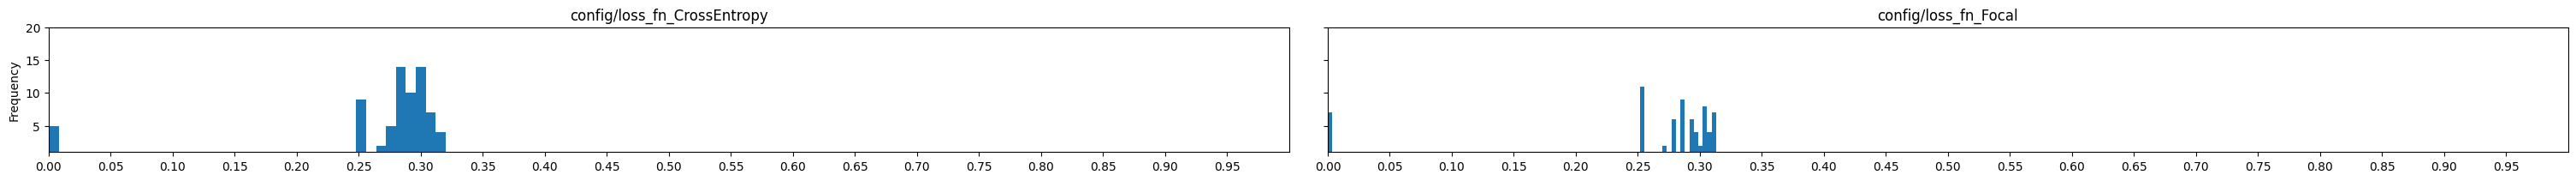

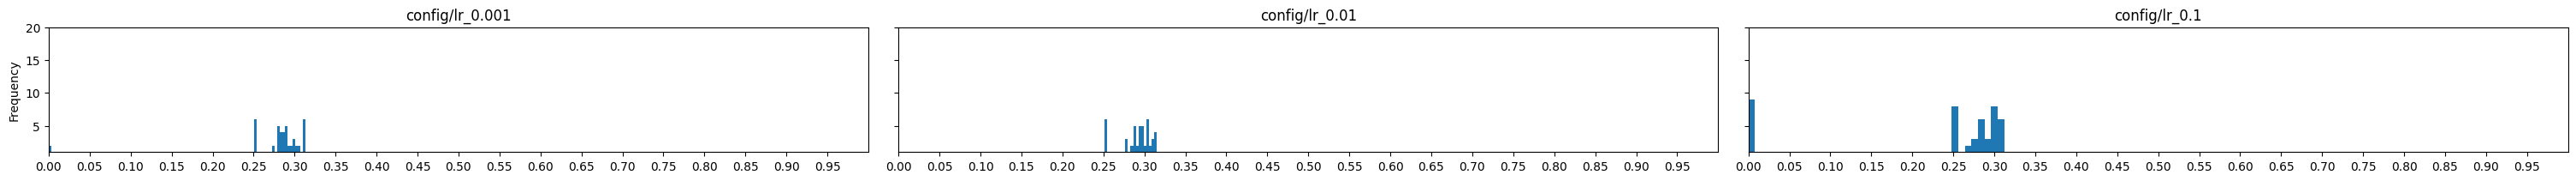

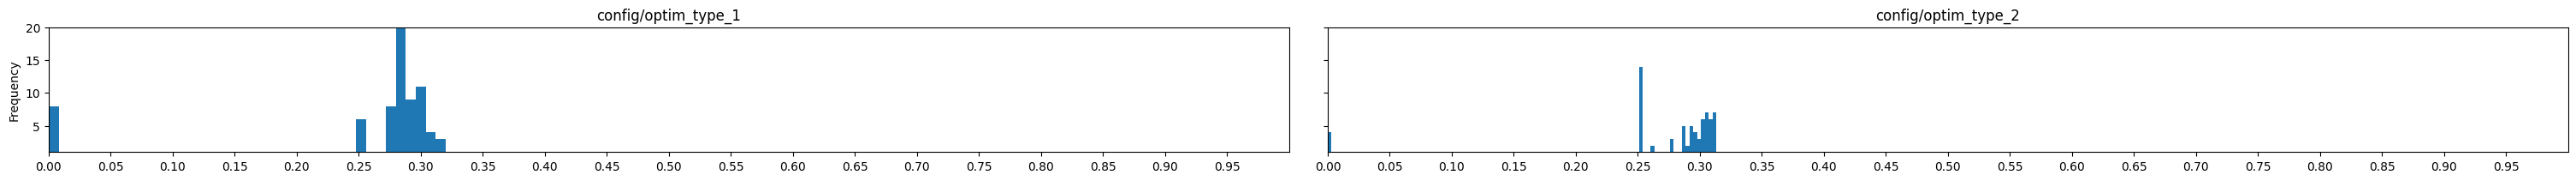

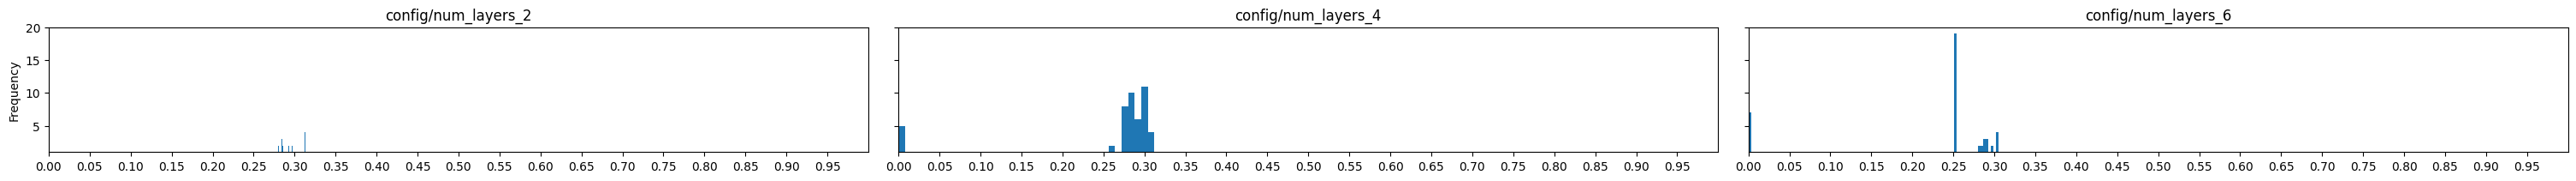

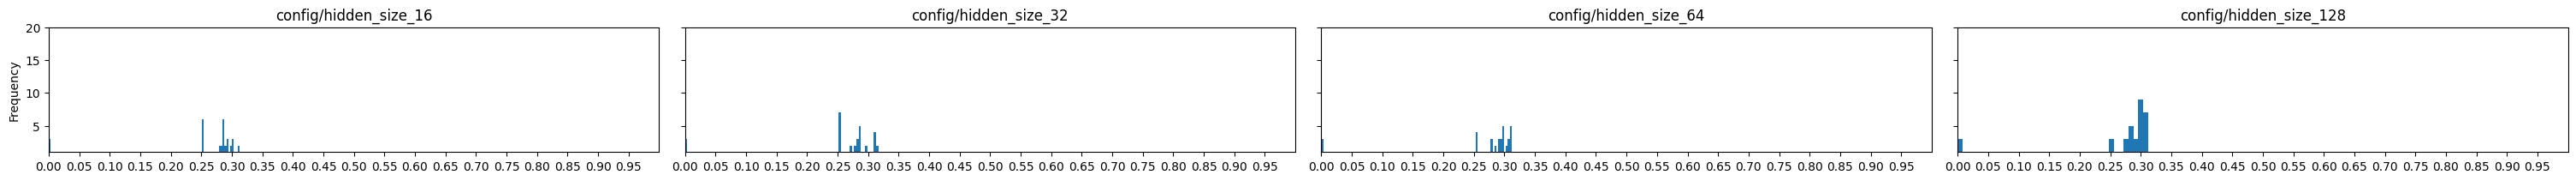

In [81]:
precision_desc = sorted_results["precision"].astype("float32").describe()
xlimit_range = [
    precision_desc["min"] - precision_desc["std"],
    precision_desc["max"] + precision_desc["std"],
]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(
        1,
        len(parameter_group),
        layout="constrained",
        sharex=False,
        sharey=True,
        figsize=(30, 2),
    )
    for i, g in enumerate(parameter_group):
        g[1]["precision"].astype("float32").plot(
            kind="hist", bins=100, subplots=True, sharex=False, sharey=True, ax=axs[i]
        )
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")
        axs[i].set_xlim([0, 1])
        axs[i].set_xticks(np.arange(0, 1, 0.05))
        axs[i].set_ylim([1, 20])  # math.ceil(144 / len(parameter_group))
    # pyplot.xlim(xlimit_range)
    pyplot.show()